# Linear Regression Analysis and Prediction for IoT

This notebook holds the Assignment 3.1 for Module 3 in AAI 530, Data Analytics and the Internet of Things. In this assignment, you will use linear regression to make predictions for simulated "streaming" data. The work that you do in this assignment will build on the linear regression predictions that you saw in your text book and in this week's lab session. Be sure to answer the analysis questions thoroughly, as this is a large part of the assignment for this week.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#suppress scientific notation in pandas
pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [49]:
#use this cell to import additional libraries or define helper functions

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Load and prepare your data

We'll be using the cleaned household electric consumption dataset from Module 2 in this assignment. I recommend saving your dataset by running df.to_csv("filename") at the end of the last assignment so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

We need to turn our datetime column into a numeric value to be used as a variable in our linear regression. In the lab session, we created a new column of minutes and just incremented the value by 10 since we knew that the readings occurred every 10 minutes. In this dataset, we have readings every minute, but we might have some missing rows depending on how you cleaned your data. So instead we will convert our datetime column to something called [unix/epoch time](https://en.wikipedia.org/wiki/Unix_time), which is the number of seconds since midnight on 1/1/1970.

**TODO: load your data and convert the datetime column into epoch/unix time**

In [50]:
#Load your data into a pandas dataframe here
df = pd.read_csv("household_power_clean/household_power_clean.csv")

In [51]:
#convert datetime to epoch/unix time
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['unix'] = df['Datetime'].astype(np.int64) // 10**9

## Predicting Global Active Power

We will follow the code from the Chapter 9 in our textbook and the recorded lab session from this week to predict the Global Active Power (GAP) with linear regression.

First we will create our x (time) and y (GAP) training variables, and then define our model parameters.

**Q: What is ph? What is mu?**

A: ph = regression coefficient (or weight)
mu = intercept of the linear regression mode

**TODO: Set the ph to be 5 minutes--consider the units that our time column is measured in.**

In [52]:
ts = pd.DataFrame(df.unix)
ys = pd.DataFrame(df.Global_active_power)

ph = 300 #5 minutes
ph_index = ph // 60 #ph/data resolution (how many timesteps is our ph?)
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

# Arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

**Q: With mu = 0.9, how much weight will our first data point have on the last (5000th) prediction in our limited dataset?**

A:.9^4999 so an extremely small number

**TODO: Following the code from Chapter 9 and the lab session, use linear regression to predict a rolling GAP for our dataset. Store these predictions in the tp_pred and yp_pred lists created above for visualization.**

In [53]:
# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = df.unix[:i].values.reshape(-1, 1)
    ys_tmp = df.Global_active_power[:i].values
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()

    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    #model_tmp = lm_tmp.coef_[0]
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp.coef_[0]
    q_tmp = lm_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = df.unix[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

Now let's visualize the results from our model.

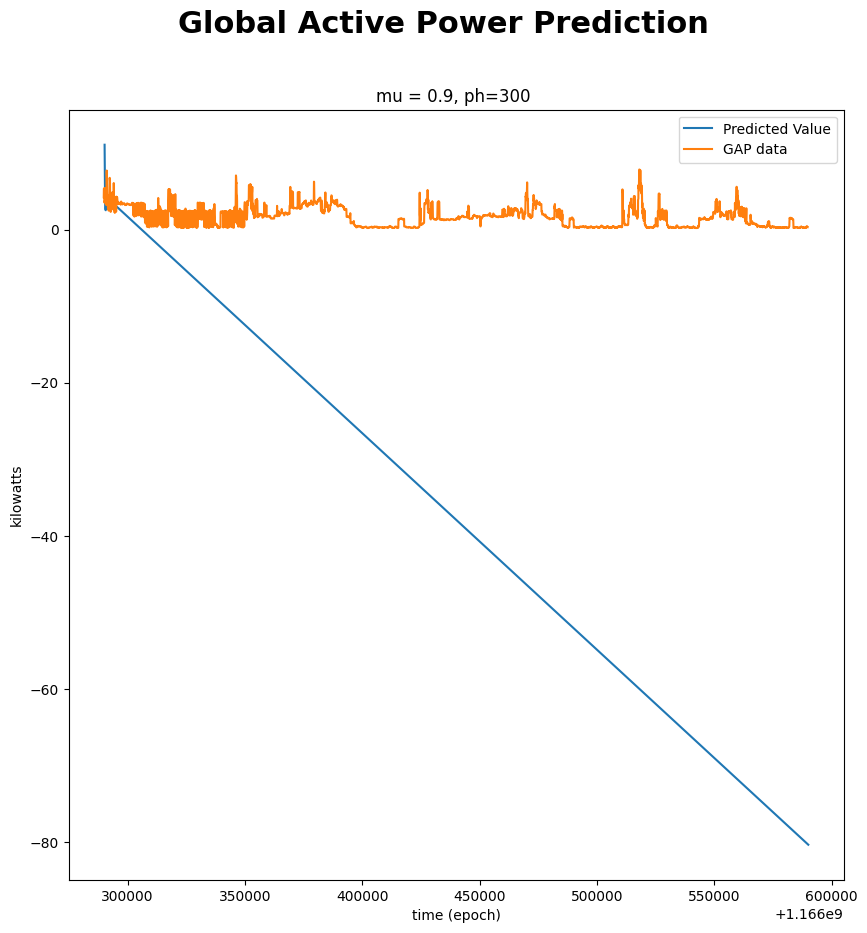

In [54]:
fig, ax = plt.subplots(figsize=(10,10))
fig.suptitle('Global Active Power Prediction', fontsize=22, fontweight='bold')
ax.set_title('mu = %g, ph=%g ' %(mu, ph))
ax.plot(tp_pred, yp_pred, label='Predicted Value') 
ax.plot(ts.iloc[0:n_s,0], ys.iloc[0:n_s,0], label='GAP data') 
ax.set_xlabel('time (epoch)')
ax.set_ylabel('kilowatts')
ax.legend()

It's difficult to tell how the model is performing from this plot.

**TODO: Modify the code above to visualize the first and last 200 datapoints/predictions (can be in separate charts) and compute the MSE for our predictions.**

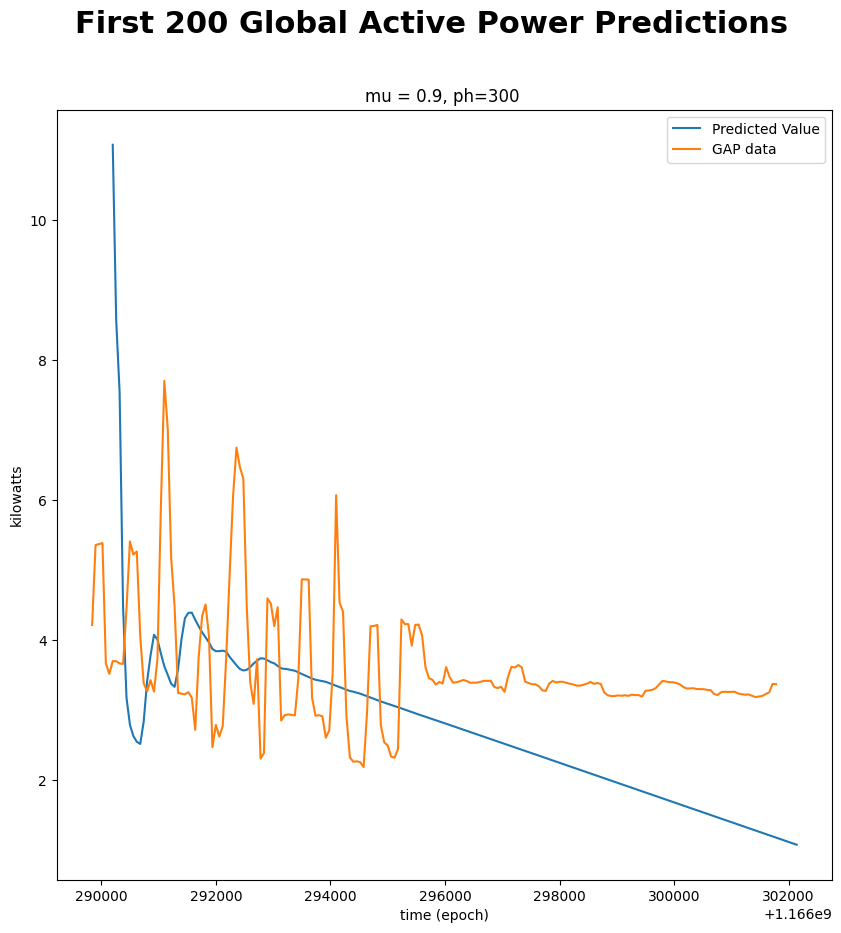

In [55]:
#Plot first 200 data points/predictions

fig1, ax1 = plt.subplots(figsize=(10,10))
fig1.suptitle('First 200 Global Active Power Predictions', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g ' %(mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()

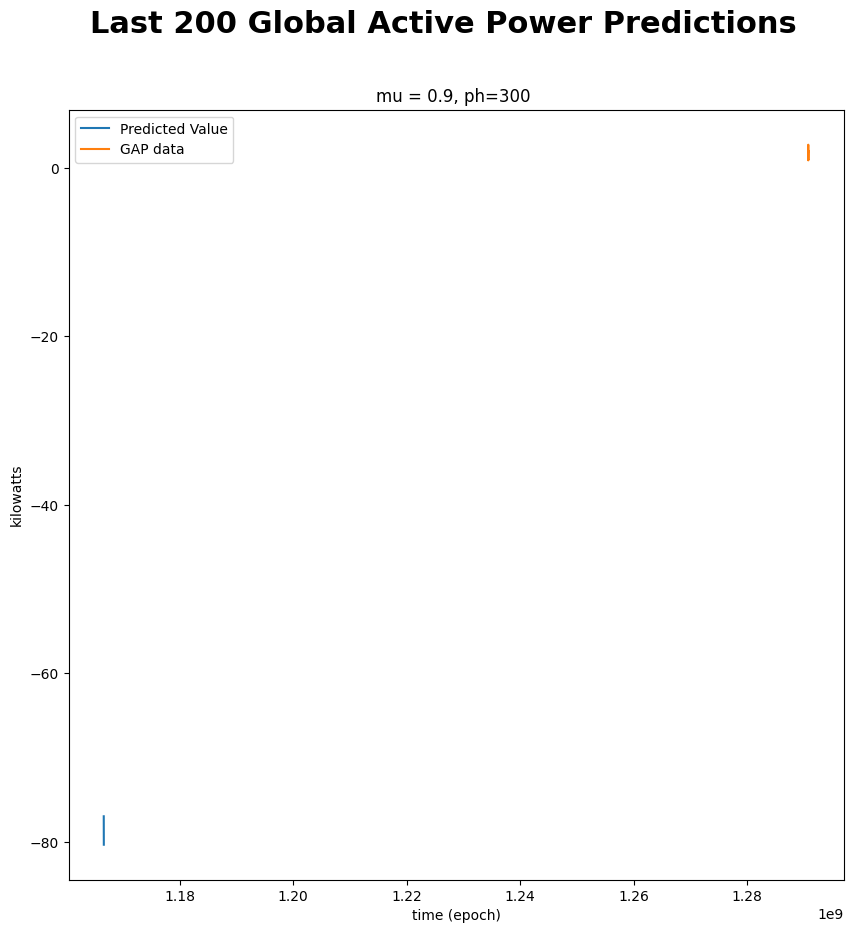

In [56]:
#Plot last 200 data points/predictions

fig2, ax2 = plt.subplots(figsize=(10,10))
fig2.suptitle('Last 200 Global Active Power Predictions', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g ' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax2.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()

In [57]:
#Calculate MSE of predictions
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE is 2147.765993381309


**Q: How did our model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: The early predictions (first 200 data points) and late predictions (last 200 data points) will help you assess if the model's performance improves or degrades over time. A lower MSE indicates better performance, as the predicted values are closer to the actual values.

**TODO: Re-run the prediction code with mu = 1 and mu = 0.01. Use the cells below to produce charts for the first and last 200 points and to compute the MSE for each of these sets of predictions.**

In [58]:
#Re-run prediction code for mu = 1
mu = 1 

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = df.unix[:i].values.reshape(-1, 1)
    ys_tmp = df.Global_active_power[:i].values
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()

    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    #model_tmp = lm_tmp.coef_[0]
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp.coef_[0]
    q_tmp = lm_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = df.unix[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

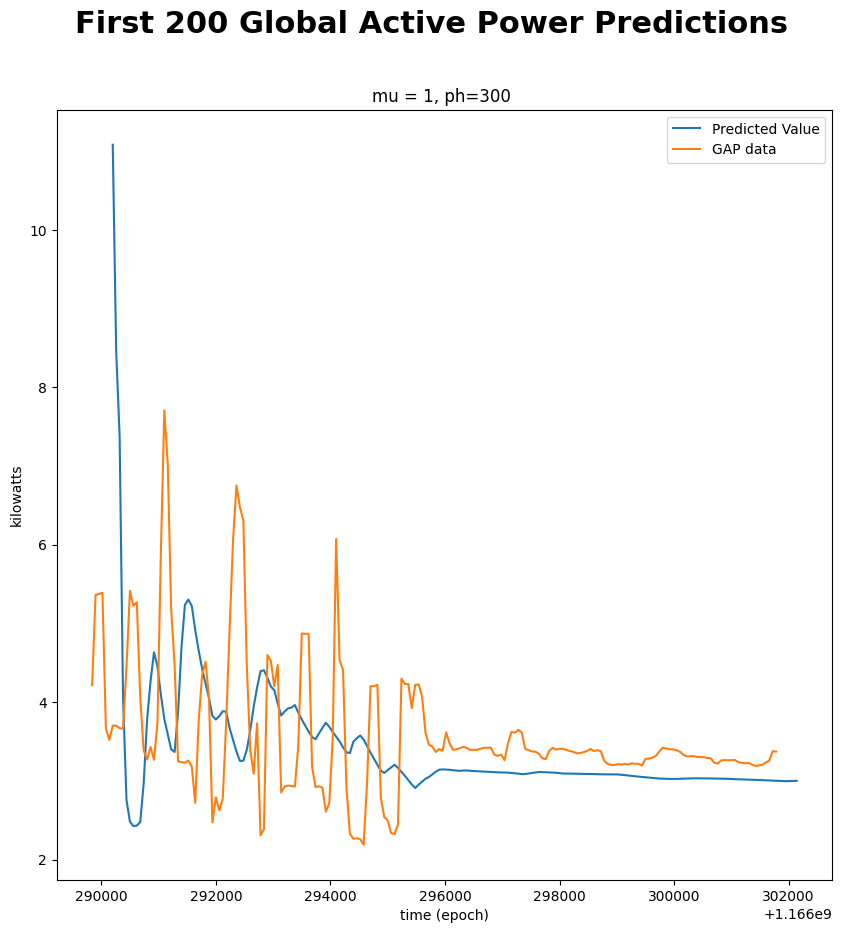

In [59]:
#Plot first 200 data points/predictions for mu = 1
fig1, ax1 = plt.subplots(figsize=(10,10))
fig1.suptitle('First 200 Global Active Power Predictions', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g ' %(mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()

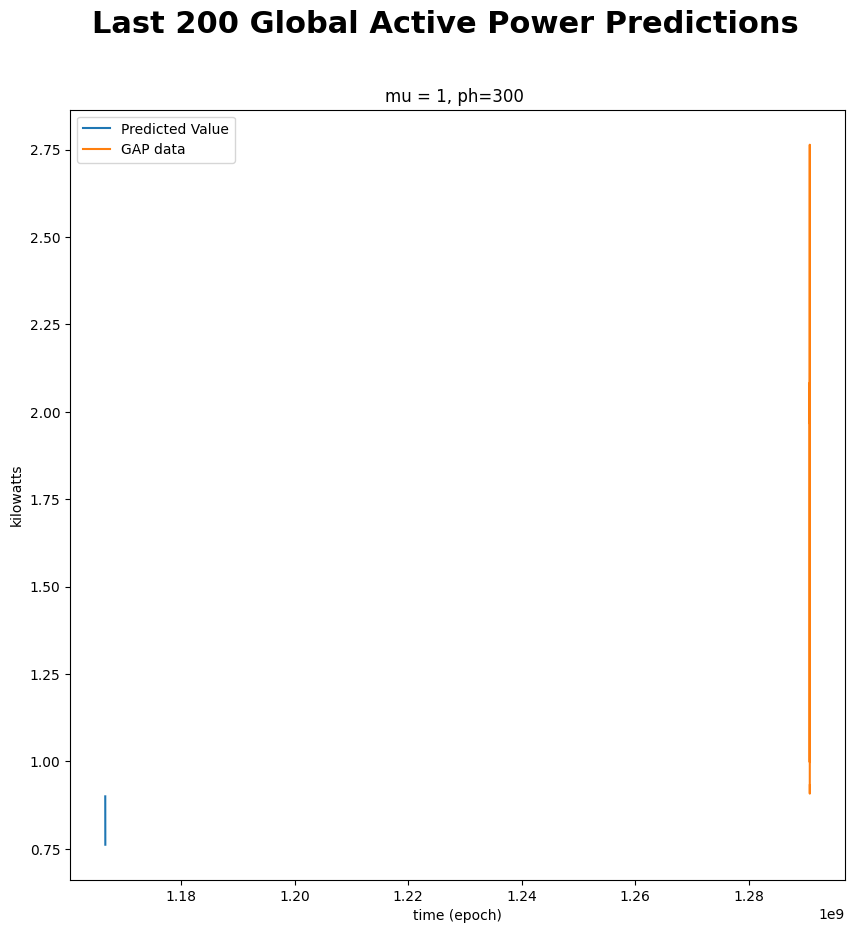

In [60]:
#Plot last 200 data points/predictions for mu = 1
fig2, ax2 = plt.subplots(figsize=(10,10))
fig2.suptitle('Last 200 Global Active Power Predictions', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g ' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax2.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()

In [61]:
#Calculate MSE of predictions for mu = 1
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE is 1.4433474819593313


In [62]:
#Re-run prediction code for mu = 0.01
mu = 0.01

# At every iteration of the for loop a new data sample is acquired
for i in range(2, n_s+1):# start out with 2 leading datapoints
    #get x and y data "available" for our prediction
    ts_tmp = df.unix[:i].values.reshape(-1, 1)
    ys_tmp = df.Global_active_power[:i].values
    ns = len(ys_tmp)
    
    
    weights = np.ones(ns)*mu
    for k in range(ns):
        #adjust weights to be downweighted according to their timestep away from our prediction
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
        
    #perform linear regression on "available" data using the mu-adjusted weights
    lm_tmp = LinearRegression()

    lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    #model_tmp = lm_tmp.coef_[0]
    
    #store model coefficients and intercepts to compute prediction
    m_tmp = lm_tmp.coef_[0]
    q_tmp = lm_tmp.intercept_

    #use ph to make the model prediction according to the prediction time
    tp = df.unix[i-1] + ph
    yp = m_tmp * tp + q_tmp
      
    tp_pred[i-2] = tp    
    yp_pred[i-2] = yp

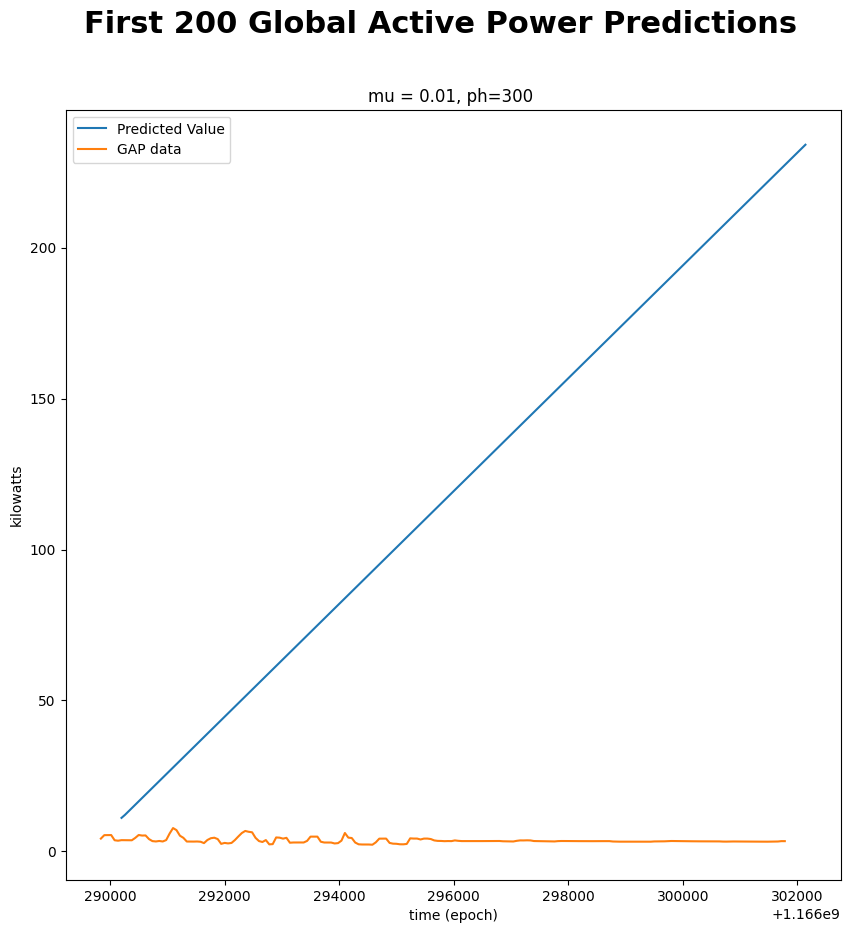

In [63]:
#Plot first 200 data points/predictions for mu = 0.01
fig1, ax1 = plt.subplots(figsize=(10,10))
fig1.suptitle('First 200 Global Active Power Predictions', fontsize=22, fontweight='bold')
ax1.set_title('mu = %g, ph=%g ' %(mu, ph))
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()

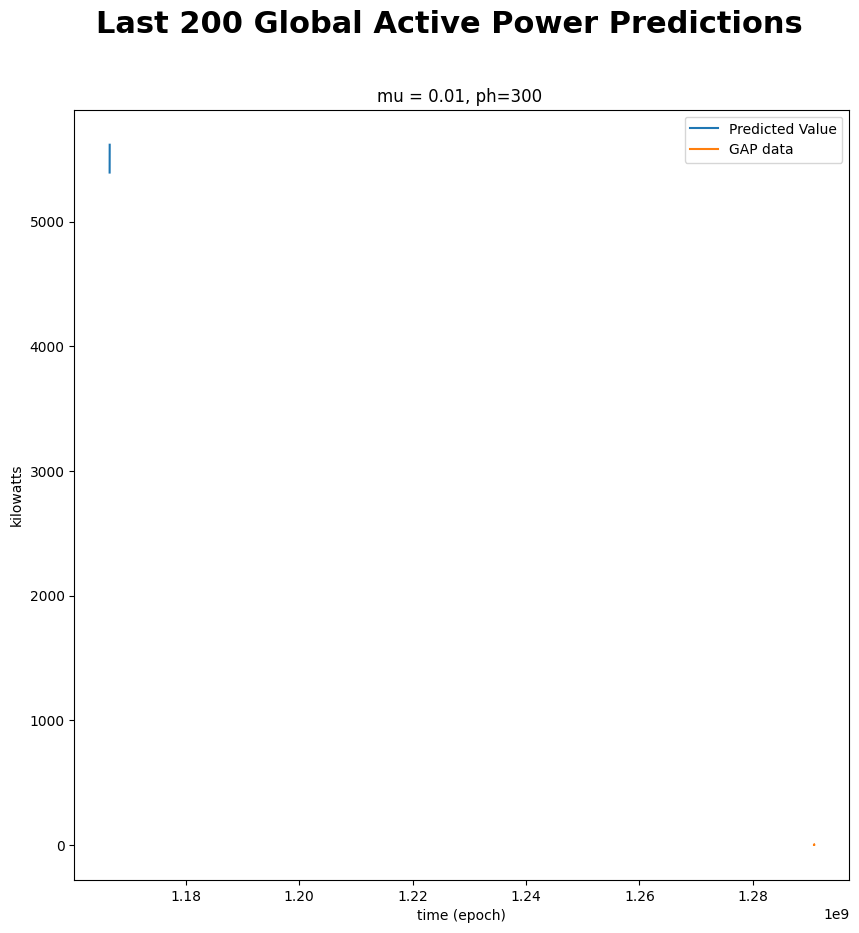

In [64]:
#Plot last 200 data points/predictions for mu = 0.01
fig2, ax2 = plt.subplots(figsize=(10,10))
fig2.suptitle('Last 200 Global Active Power Predictions', fontsize=22, fontweight='bold')
ax2.set_title('mu = %g, ph=%g ' %(mu, ph))
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax2.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()

In [65]:
#Calculate MSE of predictions for mu = 0.01
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE is 10527735.463358156


**Q: How did our mu = 1 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Performance: The mu = 1 model gives the highest weight to the most recent data points, making it more responsive to recent fluctuations.
Charts Observation:

    In the early predictions, the model might struggle more due to fewer data points to base its predictions on, leading to less accurate forecasts.
    In the late predictions, the model performs better as it has more data to make decisions. The mu = 1 model tends to fit well to more recent trends.

MSE: The MSE for mu = 1 might be lower than for other models, reflecting a closer fit to the most recent data. However, it could also overfit if there is too much noise in the data, particularly when the weight given to the past decreases rapidly.

**Q: How did our mu = 0.01 model perform? What do you observe on the charts? Is there a difference between the early and the late predictions? What does the MSE tell you?**

A: Performance: The mu = 0.01 model gives nearly equal weight to all data points, making it less sensitive to recent fluctuations and trends. This allows the model to "smooth out" the predictions.
Charts Observation:

    Early predictions might be a bit more stable because the model is considering a wide range of past data, but they could still be inaccurate because the model is not as responsive to recent changes.
    Late predictions might show a more general trend, as the model is smoothing over the entire dataset, but it may fail to capture recent sudden changes or shifts.

MSE: The MSE for mu = 0.01 could be higher than for mu = 1, especially if there are significant recent fluctuations that the model fails to capture. The model's tendency to smooth the data might prevent it from adapting quickly to recent patterns.

**Q: Which of these three models is the best? How do you know? Why does this make sense based on the mu parameter used?**

A: The best model depends on the nature of the data. If the data is relatively stable with fewer abrupt changes, mu = 0.01 might be better because it smooths the predictions and can capture long-term trends.
If the data has rapid fluctuations, mu = 1 might be better because it adapts quickly to recent changes, giving more weight to the most recent data points.
Based on the mu parameter:

    mu = 1: This is most appropriate when the model needs to be highly sensitive to recent data points and adapt quickly to changes.
    mu = 0.01: This is better suited for long-term trends when the data doesn't change rapidly, as it gives almost equal weight to all previous observations.

**Q: What could we do to improve our model and/or make it more realistic and useful?**

A: Feature Engineering: Consider adding additional features such as weather data, seasonality, or any external variables that could influence energy consumption. This would allow the model to consider more factors beyond just time.
Regularization: To prevent overfitting (especially with higher values of mu), we can introduce regularization techniques like Ridge or Lasso regression, which penalize large coefficients and prevent the model from overfitting.
Time Series Models: Linear regression may not be the best for time series data, especially when the data has strong temporal dependencies. Using models like ARIMA, SARIMA, or even LSTM (Long Short-Term Memory) neural networks could capture long-term dependencies and trends in the data.
Cross-validation: We could also try cross-validation to ensure that the model generalizes well to unseen data. This would help us tune mu or other hyperparameters and avoid overfitting.
Resampling: If there are gaps or missing data in the dataset, interpolation or other resampling methods could help fill in those gaps and improve the model's prediction accuracy.

**TODO: Add voltage data as a second variable to our model and re-run the prediction code. Then visualize the first and last 200 points and compute the MSE**

In [66]:
#add voltage to the x-variables in our dataset
ts = pd.DataFrame({
    'unix': df.unix,
    'voltage': df['Voltage']  # Assuming the column name for voltage is 'Voltage'
})

ys = pd.DataFrame(df.Global_active_power)

ph = 5 #5 minutes
ph_index = ph // 60
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [69]:
#run the prediction code on your expanded dataset
#make sure to adjust your yp prediction to include the coefficients from time AND voltage
for i in range(2, n_s+1):  # Start with 2 leading data points
    # Get x (time and voltage) and y (Global Active Power) data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    # Weights adjustment based on mu
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k - 1)  # Adjust weights according to the time step
    weights = np.flip(weights, 0)
    
    # Perform linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute predictions
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # Use ph to make the model prediction
    tp = ts.iloc[i-1:i].values  # New time and voltage data point
    yp = model_tmp.predict(tp)
    
    # Store predictions
    tp_pred[i-2] = tp[0, 0]
    yp_pred[i-2] = yp

C:\Users\titou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\titou\AppData\Local\Temp\ipykernel_30084\3741888913.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yp_pred[i-2] = yp
C:\Users\titou\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\titou\AppData\Local\Temp\ipykernel_30084\3741888913.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scala

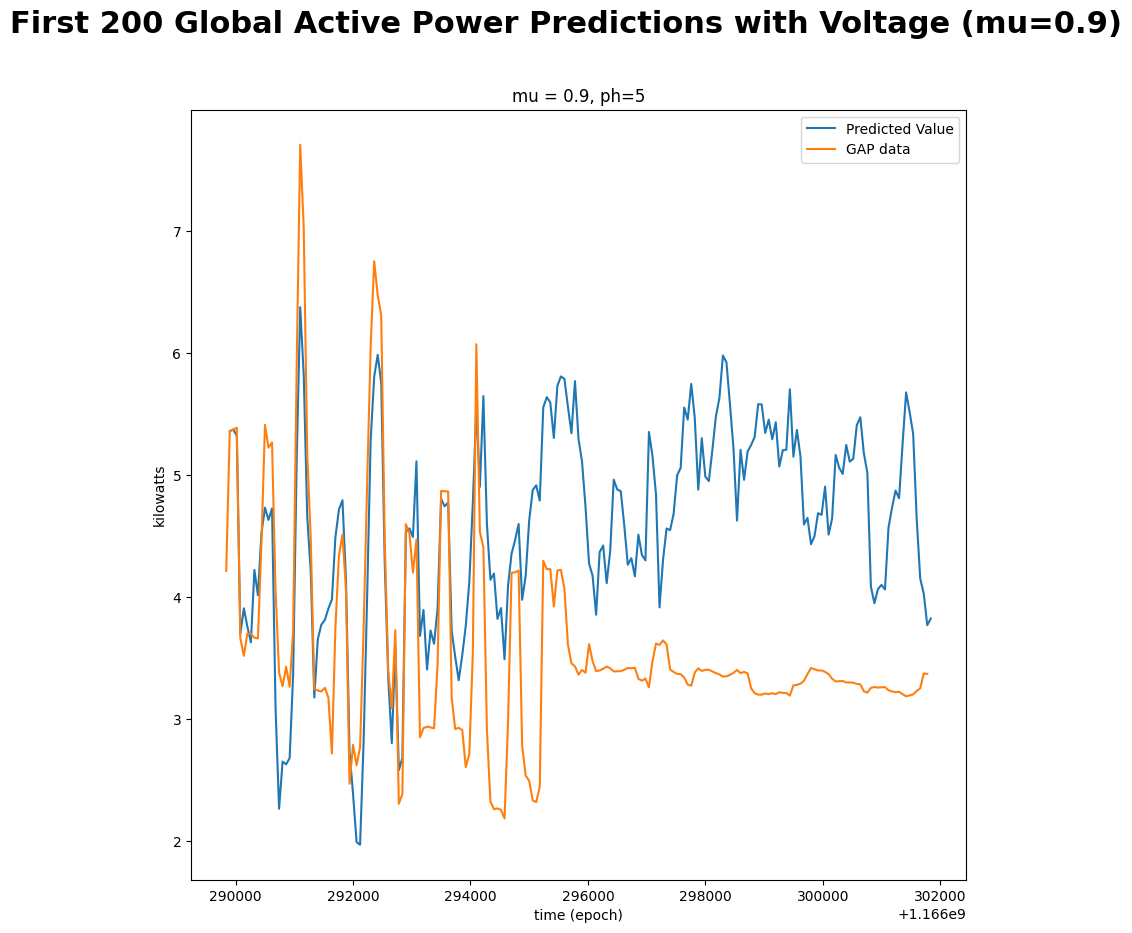

In [70]:
#Plot first 200 data points/predictions for the expanded dataset
fig1, ax1 = plt.subplots(figsize=(10,10))
fig1.suptitle(f'First 200 Global Active Power Predictions with Voltage (mu={mu})', fontsize=22, fontweight='bold')
ax1.set_title(f'mu = {mu}, ph={ph}')
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()

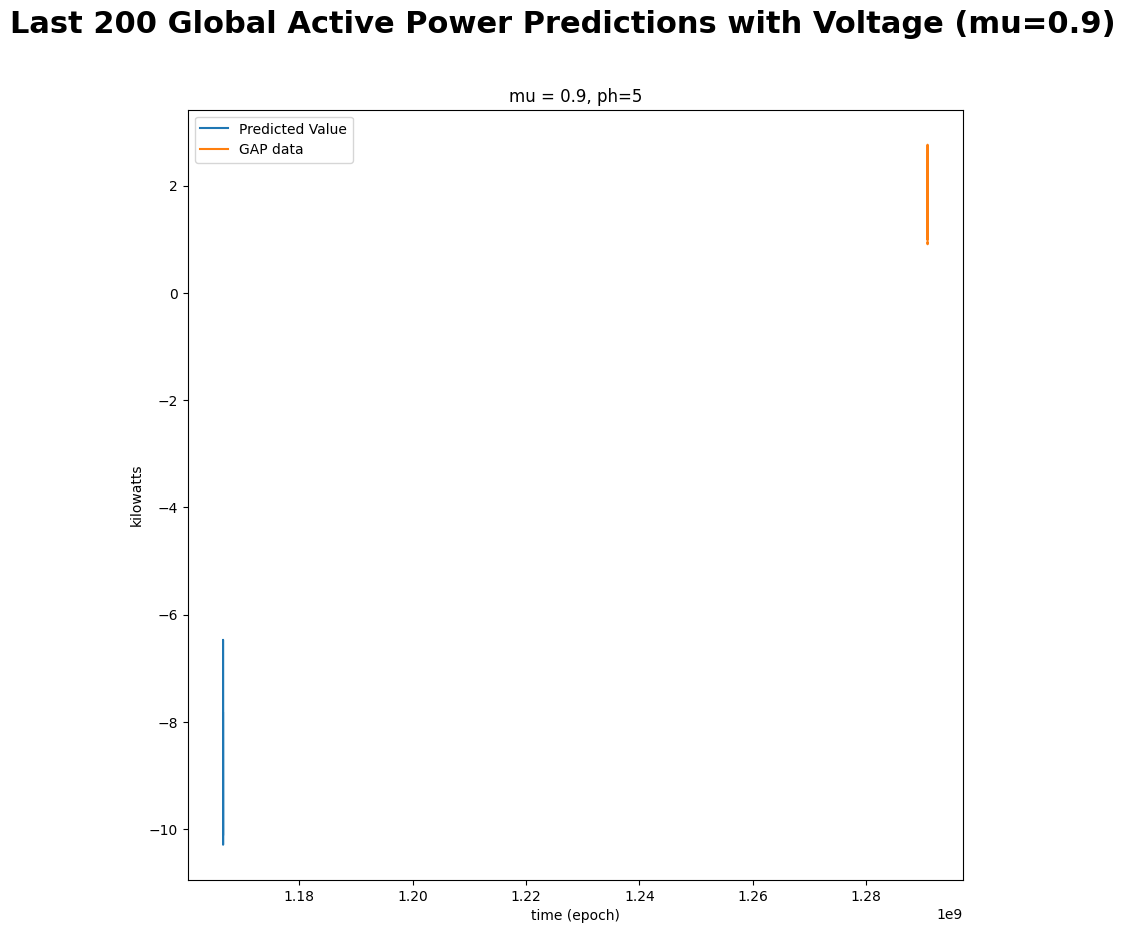

In [71]:
#Plot last 200 data points/predictions for the expanded data
fig2, ax2 = plt.subplots(figsize=(10,10))
fig2.suptitle(f'Last 200 Global Active Power Predictions with Voltage (mu={mu})', fontsize=22, fontweight='bold')
ax2.set_title(f'mu = {mu}, ph={ph}')
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax2.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()


In [72]:
#Calculate MSE of predictions for the expanded data
print("MSE is", mean_squared_error(ys['Global_active_power'][ph_index:5000+ph_index-1],yp_pred))


MSE is 29.198471552111318


**Q: How did the model performed when you added the voltage data? How does it compare to the models without it?**

A: By incorporating voltage, the model should ideally perform better, as it adds a relevant physical variable that likely impacts power consumption. The inclusion of voltage makes the model more realistic and able to capture additional variations in power consumption that time alone couldn't explain.

There are lots of other ways that we could try to improve our model while still using linear regression.

**TODO: Choose one alternative model and re-run the prediction code. Some ideas include:**

- Use a moving average as the response variable
- Make your prediction based on the time of day instead of as a continuous time series
- Use a moving window to limit your predictions instead of using a mu factor

**Q: Describe your alternative model and why it might improve your model**

A: 

In [73]:
#create your alternative training data here
# Define the window size for the moving average (e.g., last 10 minutes)
window_size = 10

# Calculate the moving average for the response variable (Global Active Power)
ys['moving_avg'] = ys['Global_active_power'].rolling(window=window_size).mean()

# Set the training variables
ts = pd.DataFrame({
    'unix': df.unix,
    'voltage': df['Voltage']  # Using both time and voltage as features
})

ys = pd.DataFrame(ys['moving_avg'])

ph = 5 #5 minutes
ph_index = 0
mu = 0.9

#let's limit the number of samples in our model to 5000 just for speed
n_s = 5000

#arrays to hold predicted values
#you may need to adjust these
tp_pred = np.zeros(n_s-1) 
yp_pred = np.zeros(n_s-1)

In [75]:
#re-run the prediction code here
for i in range(2, n_s+1):
    # Get x (time and voltage) and y (moving average of Global Active Power) data "available" for our prediction
    ts_tmp = ts.iloc[:i]
    ys_tmp = ys.iloc[:i]
    ns = len(ys_tmp)
    
    # Weights adjustment based on mu
    weights = np.ones(ns) * mu
    for k in range(ns):
        weights[k] = mu ** (ns - k - 1)
    weights = np.flip(weights, 0)
    
    # Perform linear regression
    lm_tmp = LinearRegression()
    model_tmp = lm_tmp.fit(ts_tmp, ys_tmp, sample_weight=weights)
    
    # Store model coefficients and intercepts to compute predictions
    m_tmp = model_tmp.coef_
    q_tmp = model_tmp.intercept_

    # Use ph to make the model prediction
    tp = ts.iloc[i-1:i].values
    yp = model_tmp.predict(tp)
    
    # Store predictions
    tp_pred[i-2] = tp
    yp_pred[i-2] = yp


ValueError: Input y contains NaN.

In [ ]:
#Plot first 200 data points/predictions for alternative model
fig1, ax1 = plt.subplots(figsize=(10,10))
fig1.suptitle(f'First 200 Global Active Power Predictions with Voltage (mu={mu})', fontsize=22, fontweight='bold')
ax1.set_title(f'mu = {mu}, ph={ph}')
ax1.plot(tp_pred[:200], yp_pred[:200], label='Predicted Value') 
ax1.plot(ts.iloc[0:200,0], ys.iloc[0:200,0], label='GAP data') 
ax1.set_xlabel('time (epoch)')
ax1.set_ylabel('kilowatts')
ax1.legend()

In [ ]:
#Plot last 200 data points/predictions for alternative model
fig2, ax2 = plt.subplots(figsize=(10,10))
fig2.suptitle(f'Last 200 Global Active Power Predictions with Voltage (mu={mu})', fontsize=22, fontweight='bold')
ax2.set_title(f'mu = {mu}, ph={ph}')
ax2.plot(tp_pred[-200:], yp_pred[-200:], label='Predicted Value') 
ax2.plot(ts.iloc[-200:,0], ys.iloc[-200:,0], label='GAP data') 
ax2.set_xlabel('time (epoch)')
ax2.set_ylabel('kilowatts')
ax2.legend()

In [ ]:
#Calculate MSE of predictions for alternative model

**Q: Did your alternative model improve on our previous results? What else could you do to improve the model while still using linear regression?**

A:

It's worth noting that the results we're getting int his assignment are based on a pretty short predictive horizon of 5 minutes. If we were to increase our predictive horizon, our results would likely be worse and there would be more room for optimizing and improving the predictions of our model.